# Sentiment Analysis of Twitter Posts

<!-- Notebook name goes here -->
<center><b>Notebook: Data Description, Cleaning, Exploratory Data Analysis, and Preprocessing</b></center>
<br>

**by**: Stephen Borja, Justin Ching, Erin Chua, and Zhean Ganituen.

**dataset**: Hussein, S. (2021). Twitter Sentiments Dataset [Dataset]. Mendeley. https://doi.org/10.17632/Z9ZW7NT5H2.1

**motivation**: Every minute, social media users generate a large influx of textual data on live events. Performing sentiment analysis on this data provides a real-time view of public perception, enabling quick insights into the general population’s opinions and reactions.

**goal**: By the end of the project, our goal is to create and compare supervised learning algorithms for sentiment analysis.

### **dataset description**

The Twitter Sentiments Dataset is a dataset that contains nearly 163k tweets from Twitter. The time period of when these were collected is unknown, but it was published to Mendeley Data on May 14, 2021 by Sherif Hussein of Mansoura University.

Tweets were extracted using the Twitter API, but the specifics of how the tweets were selected are unmentioned. The tweets are mostly English with a mix of some Hindi words for code-switching <u>(El-Demerdash., 2021)</u>. All of them seem to be talking about the political state of India. Most tweets mention Narendra Modi, the current Prime Minister of India.

Each tweet was assigned a label using TextBlob's sentiment analysis <u>(El‑Demerdash, Hussein, & Zaki, 2021)</u>, which assigns labels automatically.

Twitter_Data

- **`clean_text`**: The tweet's text
- **`category`**: The tweet's sentiment category

What each row and column represents: `each row represents one tweet.` <br>
Number of observations: `162,980`

---

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Code-switching is the practice of alternating between two languages $L_1$ (the native language) and $L_2$ (the source language) in a conversation. In this context, the code-switching is done to appear more casual since the conversation is done via Twitter (now, X).


# **1. Project Set-up**

We set the global imports for the projects (ensure these are installed via uv and is part of the environment). Furthermore, load the dataset here.


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import os
import sys
from wordcloud import WordCloud

# Set tqdm to pandas
tqdm.pandas()

# Use lib directory
sys.path.append(os.path.abspath("../lib"))

# Imports from lib files
from janitor import *
from lemmatize import lemmatizer
from boilerplate import stopwords_set
from bag_of_words import BagOfWordsModel

# Pandas congiruation
pd.set_option("display.max_colwidth", None)

# Load raw data file
df = pd.read_csv("../data/Twitter_Data.csv")

# **2. Data Cleaning**

This section discusses the methodology for data cleaning.


As to not waste computational time, a preliminary step is to ensure that no **`NaN`** or duplicate entries exist before the cleaning steps. We can call on `info()` after each step to see the rows changed in our DataFrame


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


There are clear inconsistencies with the amount of non-null values between column **`clean_text`** and **`category`** versus the total entries, so our first step would be to drop the `NaN` entries. We can first check which rows have **`category`** as **`NaN`**.


In [54]:
NaN_rows = df[df.isna().any(axis=1)]
NaN_rows

,clean_text,category
148,NaN,0.0
130448,the foundation stone northeast gas grid inaugurated modi came major,NaN
155642,dear terrorists you can run but you cant hide are giving more years modi which you won’ see you,NaN
155698,offense the best defence with mission shakti modi has again proved why the real chowkidar our,NaN
155770,have always heard politicians backing out their promises but modi has been fulfilling his each every,NaN
158693,modi government plans felicitate the faceless nameless warriors india totally deserved,NaN
158694,NaN,-1.0
159442,chidambaram gives praises modinomics,NaN
159443,NaN,0.0
160559,the reason why modi contested from seats 2014 and the real reason why rahul doing the same now,NaN


We found that there were a total of 11 rows that have **`NaN`** values, thus we drop them to ensure the integrity and accuracy of our data analysis.


In [55]:
df = df.dropna()
NaN_rows = df[df.isna().any(axis=1)]
NaN_rows

,clean_text,category


Another issue found commonly in real-world datasets would be duplicate rows, often from manual data entry errors, system glitches, or when merging data from multiple, overlapping sources. We can first check for duplicates in our `DataFrame` then remove them.


In [56]:
duplicate_rows = df[df.duplicated()]
duplicate_rows

,clean_text,category


There exist no duplicate rows within our `DataFrame`.


By converting a CSV file into a DataFrame, pandas automatically defaults numeric values to `float64` when it encounters decimals or **`NaN`** types. Text of `str` type get inferred and loaded into a `object` as the generic type for strings. We can check the dtype of our `DataFrame` columns through [`info()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html)


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


We can see that **`clean_text`** column dtype is of `object` and category is of dytpe `float64`, to determine if the columns are assigned the right data type we check the unqiue values in each column.


In [58]:
for item in df["category"].unique():
    print(item)

-1.0
0.0
1.0


In [59]:
for item in df["clean_text"].unique()[:3]:
    print(item)

when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
talk all the nonsense and continue all the drama will vote for modi 
what did just say vote for modi  welcome bjp told you rahul the main campaigner for modi think modi should just relax


Now that we have seen the unique values of each column, we can safely say that the data types assigned to both columns were not the right ones.


We first will convert column **`category`** from `float64` to `int64` considering that the range of values (**`-1`**, **`0`**, **`1`**) for a tweet's sentiment category will only ever be whole numbers. This step is done after dropping **`NaN`** value rows because **`NaN`** is fundamentally a float type.


In [60]:
df["category"] = df["category"].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  object
 1   category    162969 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


After successfully converting the **`category`** column into `int64`, next we convert column `clean_string` from `object` type into the pandas defined `string` type for consistency and better performance.


In [61]:
df["clean_text"] = df["clean_text"].astype("string")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  string
 1   category    162969 non-null  int64 
dtypes: int64(1), string(1)
memory usage: 3.7 MB


We are now finished with the _initial_ data cleaning steps, this level is more focused on the standard or common issues present in public datasets and the cleaning of it before we move onto our main cleaning pipeline, which would be more focused on cleaning the tweets themselves.


## **Main Cleaning Pipeline**

We follow a similar methodology for data cleaning presented in (George & Murugesan, 2024).


### **Normalization**

Due to the nature of the text being tweets, the presence of emojis and accented characters are to be expected. To see if our data has these special characters, we selected a sample set of them to be displayed if they were in **`clean_text`**.


In [ ]:
# Finding a sample of rows with emojis
rows_with_emojis = df[df["clean_text"].str.contains(r"[\u263a-\U0001f645]", regex=True)]
rows_with_emojis["clean_text"].sample(5)

In [13]:
# Finding a sample of rows with accented characters
accented_char_rows = df[df["clean_text"].str.contains(r"É|é|Á|á|ó|Ó|ú|Ú|í|Í")]
accented_char_rows["clean_text"].sample(5)

36103                                                     sir this country politicians dont jail each other otherwise modi would have never been let off guj riot case plus there were numerous other corruption exposé vinod rai cag but cong didnt want jail modi 
90685     modi has patent relating infant body composition pending her employer imperial college london has established research innovation partnership with nestlé research ellis chair tropical health education trust that receives funding from commercial orgs 
97413                                                                                                                                                        sir please one exposé about the degree modi also everyone wants see his degree entire political science
134364                                                                                        india all these small political parties wolfs many years they enjoyed the kill together modi the lion made their life miser

Although in a real-world context these do serve as a form of emotional expression, they provide no relevance towards _textual_ sentiment analysis, thus we normalize the text.


To normalize the text, the `normalize` function was created. It normalizes the text input to ASCII-only characters (say, "cómo estás" becomes "como estas") and lowercased alphabetic symbols. The dataset contains Unicode characters (e.g., emojis and accented characters) which the function replaces to the empty string (`''`).


In [14]:
normalize??

### **Punctuations**

Punctuations are part of natural speech and reading to provide a sense of structure, clarity, and tone to sentences, but in the context of a classification study, punctuations do not add much information to the sentiment of a message. The sentiment of `i hate you!` and `i hate you` are going to be the same despite the punctuation mark `!` being used to accentuate the sentiment. We can see a sample of rows with punctations below.


In [15]:
# Finding a sample of rows with punctuation
rows_with_punc = df[df["clean_text"].str.contains(r"[^\w\s]")]
rows_with_punc["clean_text"].sample(5)

120472    war terror won’ get out any those places that’ the point war terror line the pockets weapons manufacturers her being against regime change does very little this equation aside from her endorsements authoritarians like modi assad
138445               not true ’ personally not want get reelected coz think ’ not good for the and indian people india has dramatically turned violent towards minorities but many pakistanis want modi back power coz ’ hurting not pakistan 
40947                                                                                                                                                                   fan opens modithemed cafe tamil nadus thoothukudi link … via namo app 
15007                     the abuses hurled come from place anger hate and frustration but don’ believe responding the same coin how can you hate anyone who teaches you something the may hate but heart have only love for him rahul gandhi 
102964                                      

To address this, the function `rem_punctuation` was made, which replaces all punctuations and special characters with an empty string (`''`)


In [16]:
rem_punctuation??

### **Numbers**

Similar to punctuations, numbers do not add any information to the sentiment of a message.


In [17]:
# Finding a sample of rows that contain numbers
rows_with_numbers = df[df["clean_text"].str.contains(r"\d")]
rows_with_numbers["clean_text"].sample(5)

138722                                                                                2014 only voted for mrmodithis time will much lesser they must bang their heads shame after 23rd
51300     modi actually time traveller from the past read this article from 2012 this man will anything win elections and recreate his image the developmentman exactly what did 2014 
105831    dunno did the telegraph use the same trick against modi 2014 which modi using against the congress now  should careful didnt work against him then has reason work now link 
17130                                          srategies bloody syrategie world here emotions mere cacuclations additions substractions our nsa modi 1of best such caluclations world 
143514                                                                                                  his £10000 ostrich jacket hasnt been lucky for him ever since was discovered  
Name: clean_text, dtype: string

Hence, we defined the `rem_numbers` as a function that replaces all numerical values as an empty string (`''`).


In [18]:
rem_numbers??

### **Whitespace**

Similar to punctations, whitespaces do not add any information to the text and are from user errors. We check if our data has whitespace.


In [19]:
# Finding a sample of rows that contain 2 or more whitespaces in a row
rows_with_whitespaces = df[df["clean_text"].str.contains(r"\s{2,}")]
rows_with_whitespaces["clean_text"].sample(5)

132452                                                                                     finally der standing and screamingfor black assets which going looted modi  
58406     works friend mine changed his birth year twitter 2007 and this what happened\ntry only you are diehard namo fan spread the word your fellow modi supporters  
56950             nowhere are politicians seen perfect our loyalties were usually circumspect\nbut must choose\nthe better the two\nand only modi who has our respect  
128072                    still waiting for lakhs bank well  many online chowkidars online  only one gives this lakhs  will return after modi deposits account promise 
161010         modi should salute every indian coz during demonetisation scam they were stood you but per the tendency history bjp rss modi deceive them horrifically  
Name: clean_text, dtype: string

Thus to address the problem, the function `collapse_whitespace` was made, which collapses all whitespace characters to a single space. Formally, it is a transducer

$$
\Box^+ \mapsto \Box \qquad \text{where the space character is } \Box
$$

Informally, it replaces all strings of whitespaces to a single whitespace character.


In [20]:
collapse_whitespace??

To seamlessly call all these cleaning functions, we have the `clean` function that acts as a container that calls these separate components. The definition of this wrapper function is quite long, see [this appendix](#appendix:-clean-wrapper-function-definition) for its definition.

We can now clean the dataset and store it in a new column named `clean_ours` (to differentiate it with the, still dirty, column `clean_text` from the dataset author)


In [21]:
df["clean_ours"] = df["clean_text"].map(clean).astype(dtype="string")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  string
 1   category    162969 non-null  int64 
 2   clean_ours  162969 non-null  string
dtypes: int64(1), string(2)
memory usage: 5.0 MB


To confirm if the character cleaning worked, we can check for the differences between `clean_text` and `clean_ours` from the filtered rows below and compare the differences.


In [22]:
example_rows = df[
    df["clean_text"].str.contains(r"\s{2,}|\d|[^\w\s]|[\u263a-\U0001f645]|[ÉéÁáóÓúÚíÍ]")
]
example_rows.sample(10)

,clean_text,category,clean_ours
3639,shabana azmi modi’ biopic credit row was done mislead public read more,1,shabana azmi modi biopic credit row was done mislead public read more
28246,the niceties which you bullock modi 2014 your viral fever came down too soon,-1,the niceties which you bullock modi your viral fever came down too soon
92676,blame the equipment not modi’ extremist policy,0,blame the equipment not modi extremist policy
15271,modi for vision rahul for division all others for televisions \nplease share,0,modi for vision rahul for division all others for televisions \nplease share
73854,bharatiya janata party ministers immediately took twitter congratulate the government using the party’ slogan ‘the impossible now possible’,-1,bharatiya janata party ministers immediately took twitter congratulate the government using the party slogan the impossible now possible
107595,narendra modi breathes “this election gimmick could have held his breath least until elections were over”,-1,narendra modi breathes this election gimmick could have held his breath least until elections were over
136,achhe din vikas black money jobs the only thing found post2014 new india ➡ modi lies,-1,achhe din vikas black money jobs the only thing found post new india modi lies
147698,absolutely spot maam every one voting for modi alone irrespective who the nda his constituency,1,absolutely spot maam every one voting for modi alone irrespective who the nda his constituency
131761,indira gandhi was successful dividing pakistan 1971 but modi successful uniting pakistanis and the terrorists 2019 just this the difference hope rajnathji will understand,1,indira gandhi was successful dividing pakistan but modi successful uniting pakistanis and the terrorists just this the difference hope rajnathji will understand
40087,under modi and cbi visit all congress men daily extortion racket nothing new ’ was common practice gujrat,-1,under modi and cbi visit all congress men daily extortion racket nothing new was common practice gujrat


We are now finished with basic text cleaning, but the data cleaning does not end here. Given that the text is sourced from Twitter, it includes characteristics, such as spam and informal expressions, which are not addressed by basic cleaning methods. As a result, we move on to further cleaning tailored to the nature of Twitter data.


### **Spam, Expressions, Onomatopoeia, etc.**

Since the domain of the corpus is Twitter, spam (e.g., `bbbb`), expressions (e.g., `bruhhhh`), and onomatopoeia (e.g., `hahahaha`) may become an issue by the vector representation step. Hence we employed a simple rule-based spam removal algorithm.

We remove words in the string that contains the same letter or substring thrice and consecutively. These were done using regular expressions:

$$
\text{same\_char\_thrice} := (.)\textbackslash1^{\{2,\}}
$$

and

$$
\text{same\_substring\_twice} := (.^+)\textbackslash1^+
$$

Furthermore, we also remove any string that has a length less than three, since these are either stopwords (that weren't detected in the stopword removal stage) or more spam.

Finally, we employ adaptive character diversity threshold for the string $s$.

$$
\frac{\texttt{\#\_unique\_chars}(s)}{|s|} < 0.3 + \left(\frac{0.1 \cdot \text{min}(|s|, 10)}{10}\right)
$$

It calculates the diversity of characters in a string; if the string repeats the same character alot, we expect it to be unintelligible or useless, hence we remove the string.

The definition of this wrapper function is quite long, see its definition in [this appendix](#appendix:-find_spam_and_empty-wrapper-function-definition).

Let's first look at a random sample of 10 entries from the dataset that will be modified by the function.


In [23]:
affected = df[df["clean_ours"].apply(spam_affected)]
affected_sample = affected["clean_ours"].sample(10)
affected_sample

57918                                                                         does have dreams modi absurd him that his all act looking drama but still not able understand that elected india not like mmsingh who obey your order thinking
56839                                                                                                           teach iitians about pushpak viman from ramayana not about wright brothers said modis hrd mos this bjprss idea space research
48600                                                      but tumhare modi abba kyun chale aate hain saal tha haath mein institute excellence bana dete sirf credit lene jate hain did not even mentioned the name head this asat programme
31127                                                               geetaji yeh sab aap rehne selective media personal statements against modi and yogi why you journalists keep silent then dynastic loyalty more important than the nation
44995                pmmodi special for reasons indi

Let's now call this function on the `clean_ours` column of the dataset.


In [24]:
df["clean_ours"] = df["clean_ours"].map(find_spam_and_empty).astype("string")

To confirm if the function was able to do remove all the spammy substrings, we can check `before` and `after` to compare their differences.


In [25]:
comparison = pd.DataFrame({"before": affected_sample, "after": df["clean_ours"]})

changed = comparison[comparison["before"] != comparison["after"]]
changed.sample(10)

,before,after
161623,feel should trio modi mamta raga maza aajayega should have debate every election like usa where the presidential candidates have debate and should moderated anchors every channel,feel should trio modi mamta raga maza should have debate every election like usa where the presidential candidates have debate and should moderated anchors every channel
120950,did ppl ask for any proof from vajpayee from indira rajiv deve gowda gujaral any other that has run the government india why are ppl only asking for proof modi his sarkar coz his sarkar the most corrpuct biggest liar all times,did ask for any proof from vajpayee from indira rajiv deve gowda gujaral any other that has run the government india why are only asking for proof modi his sarkar coz his sarkar the most corrpuct biggest liar all times
98057,now get why they are sooooo filled with venom against the modi sarkar,now get why they are filled with venom against the modi sarkar
3393,hahaha only shows your desperation modi winning even raul knows that why promising k month and k year,only shows your desperation modi winning even raul knows that why promising month and year
53615,election commn shud stay the release the film modi during election period upto th may released this will major favour modi and bjp and against opposition election comm shud play and show itself neutral not favouring modi,election commn shud stay the release the film modi during election period upto may released this will major favour modi and bjp and against opposition election comm shud play and show itself neutral not favouring modi
44995,pmmodi special for reasons india only the th country acquire such specialised modern capability entire effort indigenous india stands tall space power will make india stronger even more secure and will further peace,pmmodi special for reasons india only the country acquire such specialised modern capability entire effort indigenous india stands tall space power will make india stronger even more secure and will further peace
56839,teach iitians about pushpak viman from ramayana not about wright brothers said modis hrd mos this bjprss idea space research,teach about pushpak viman from ramayana not about wright brothers said modis hrd mos this bjprss idea space research
31127,geetaji yeh sab aap rehne selective media personal statements against modi and yogi why you journalists keep silent then dynastic loyalty more important than the nation,geetaji yeh sab rehne selective media personal statements against modi and yogi why you journalists keep silent then dynastic loyalty more important than the nation
57918,does have dreams modi absurd him that his all act looking drama but still not able understand that elected india not like mmsingh who obey your order thinking,does have dreams modi absurd him that his all act looking drama but still not able understand that elected india not like who obey your order thinking
48600,but tumhare modi abba kyun chale aate hain saal tha haath mein institute excellence bana dete sirf credit lene jate hain did not even mentioned the name head this asat programme,but tumhare modi abba kyun chale hain saal tha haath mein institute excellence bana dete sirf credit lene jate hain did not even mentioned the name head this asat programme


Let’s examine whether applying this function has caused any significant changes to the DataFrame structure, given that it can convert entire cells to `NaN`.


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  string
 1   category    162969 non-null  int64 
 2   clean_ours  162942 non-null  string
dtypes: int64(1), string(2)
memory usage: 5.0 MB


The DataFrame structure is intact, but **`clean_ours`** now has 27 fewer non-null values, reflecting cells that were entirely filtered out as spam as seen below.


In [27]:
spam_rows = df[df["clean_ours"].isna()]
spam_rows[["clean_text", "clean_ours"]]

,clean_text,clean_ours
21806,bjpmpsubramanianswamyiamchowkidarcampaignpmmodi,<NA>
21855,terrorfundinghurriyatleaderspropertyseizedhafizsaeedmodigovt,<NA>
24148,pmnarendramodirequestsofexservicemanindianarmyhavildarombirsinghsharma9258,<NA>
35636,2019,<NA>
35866,‍,<NA>
35968,whattttttt,<NA>
37837,allllll,<NA>
40587,1145am,<NA>
40977,⌚1145 ❤,<NA>
48127,birthdaaaaaay,<NA>


## **Post-Cleaning Steps**

At some point during the cleaning stage, some entries of the dataset could have been reduced to `NaN` or the empty string `""`, or we could have introduced duplicates again. So, let's call `dropna` and `drop_duplicates` again to finalize the cleaning stage.


In [28]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162942 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162942 non-null  string
 1   category    162942 non-null  int64 
 2   clean_ours  162942 non-null  string
dtypes: int64(1), string(2)
memory usage: 5.0 MB


In [29]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162942 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162942 non-null  string
 1   category    162942 non-null  int64 
 2   clean_ours  162942 non-null  string
dtypes: int64(1), string(2)
memory usage: 5.0 MB


# **3. Exploratory Data Analysis and Pre-processing**

With the dataset cleaned and ready for analysis, the next step is to explore its characteristics. Exploratory Data Analysis (EDA) uncovers patterns, highlights anomalies, and reveals feature distributions, and insights that guide how we prepare the data and which models might perform best.

> Notes from Zhean: <br>
> From manual checking via OpenRefine, there are a total of 162972. `df.info()` should have the same result post-processing.
> Furthermore, there should be two columns, `clean_text` (which is a bit of a misnormer since it is still dirty) contains the Tweets (text data). The second column is the `category` which contains the sentiment of the Tweet and is a tribool (1 positive, 0 neutral or indeterminate, and -1 for negative).


We begin by analyzing the distribution of categories.


This is done because we will be splitting this dataset later, we need to know if the distribution of the categories is balanced. An imbalanced distribution may cause a bias to the majority class. Understanding the distribution will inform us whether stratified splitting is necessary so that we do not have an under or overrepresented class.

We'll be using a bar graph as that is the simplest way for us to see the differences between the categorical data.


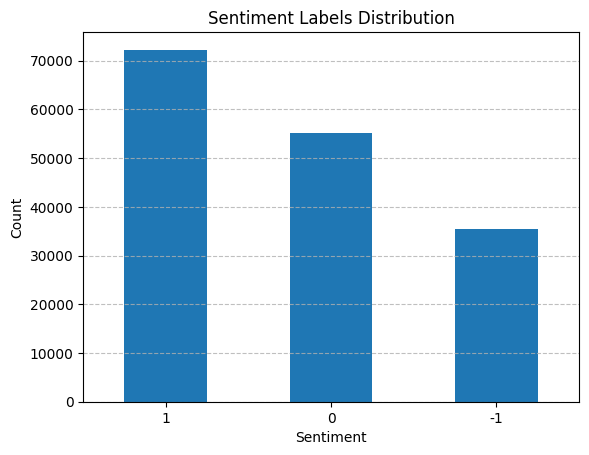

category
 1    72249
 0    55184
-1    35509
Name: count, dtype: int64


In [30]:
count = df["category"].value_counts()

plt.title("Sentiment Labels Distribution")

count.plot(kind="bar")
plt.xlabel("Sentiment")
plt.xticks(rotation=0)

plt.ylabel("Count")

plt.grid(axis="y", linestyle="--", alpha=0.8)  # horizontal lines

plt.show()
print(count)

We can see that there is a noticeable difference between the three classes. The positive class (1) has a count of over 72,000, the neutral class (0) has around 55,000, and the negative class (-1) has around 35,000.

Let's look the proportions of the three classes to check if the imbalance is significant.

In [31]:
proportions = df["category"].value_counts(normalize = True)
print(proportions)

category
 1    0.443403
 0    0.338673
-1    0.217924
Name: proportion, dtype: float64


Let's now examine the size of the vocabulary to understand the range of words in our dataset and why keeping it manageable is important.


In [32]:
all_words = df["clean_ours"].str.split().explode()

# Count unique words
unique_words_count = all_words.nunique()

print("Number of unique words:", unique_words_count)

Number of unique words: 98694


Even after cleaning, the dataset's vocabulary is still quite large. Reducing it helps focus on meaningful words, avoids bias from rare terms, and keeps the numerical representation compact for machine learning models. To further reduce the vocabulary without losing relevant information, we can apply **lemmatization**, which converts words to their base or dictionary form.


For `lemmatization`, we use the SpaCy's `en_core_web_sm` version 3.8.0, which is a pretrained language model for English <u>(Honnibal et al., 2020)</u>.


In [33]:
# df["lemmatized"] = df["clean_ours"].progress_apply(lemmatizer)
# df.to_csv("../data/data_post_lemma.csv", index=False)

# Uncomment this after running lemmatization cell once
df = pd.read_csv("../data/data_post_lemma.csv")
df["lemmatized"] = df["lemmatized"].astype(
    "string"
)  # Since its deaful is object, change it to a string

In [34]:
all_words = df["lemmatized"].str.split().explode()

# Count unique words
unique_words_count = all_words.nunique()

print("Number of unique words:", unique_words_count)

Number of unique words: 89509


From **98694** to **89509**, the `lemmatizatizer` was able to reduce the vocabulary by 9185 words.


> Provide explanation that the lemmatization did not lemmatized all words that have to be lammatized. Provide the effects of the error and that we are aware about it.


We can reduce the vocabulary (and row count) even further without losing relevant infromation, and it is by removing **stop words**. But by removing stop words, we also reduce the number of words in a tweet.

Before removing the stop words let us look at the length of the tweets.


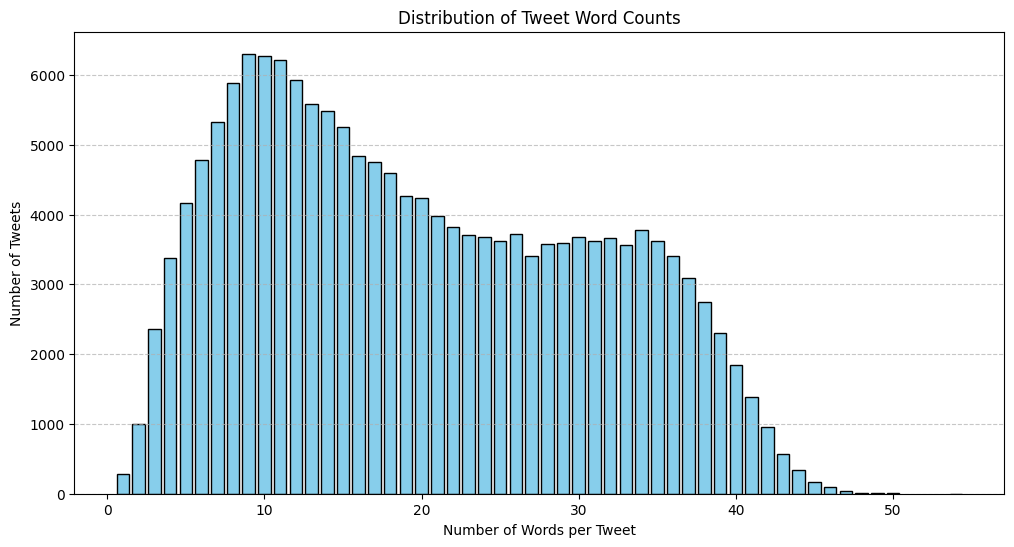

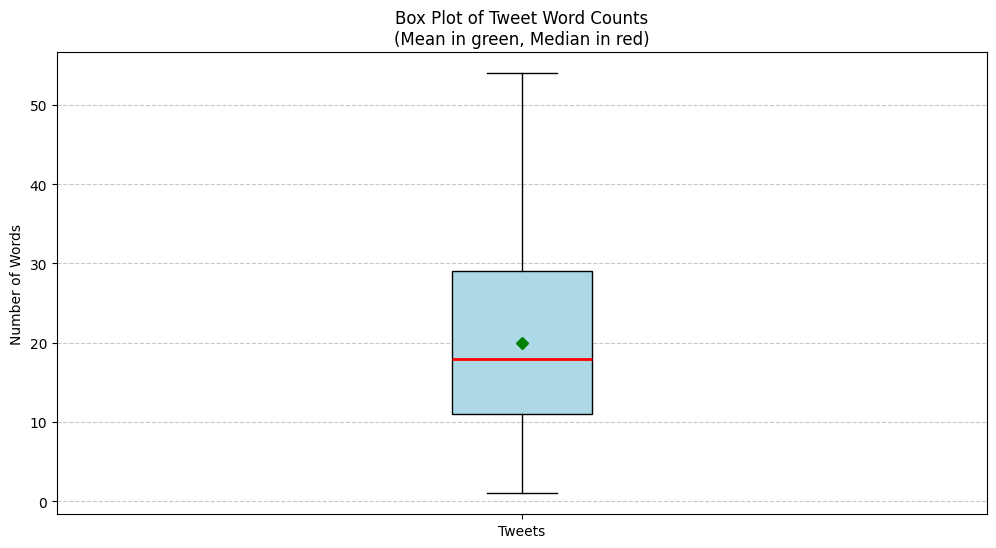

count    162942.000000
mean         19.914957
std          10.842125
min           1.000000
25%          11.000000
50%          18.000000
75%          29.000000
max          54.000000
Name: lemmatized, dtype: float64


In [35]:
# Function to count words in a string, ignoring punctuation
def count_words(text):
    # Remove punctuation using regex
    text_clean = re.sub(r"[^\w\s]", "", text)  # keep only letters, numbers, whitespace
    # Split by whitespace and count words
    return len(text_clean.split())


# Compute number of words for each tweet
word_counts = df["lemmatized"].apply(count_words)

# Count number of tweets for each word count
counts = word_counts.value_counts().sort_index()

# Plot vertical bar chart
plt.figure(figsize=(12, 6))
plt.bar(x=counts.index, height=counts.values, color="skyblue", edgecolor="black")
plt.xlabel("Number of Words per Tweet")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Tweet Word Counts")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Create box plot
plt.figure(figsize=(12, 6))
box = plt.boxplot(
    word_counts,
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),
    medianprops=dict(color="red", linewidth=2),
    showmeans=True,
    meanprops=dict(marker="D", markeredgecolor="green", markerfacecolor="green"),
)
plt.ylabel("Number of Words")
plt.title("Box Plot of Tweet Word Counts\n(Mean in green, Median in red)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([1], ["Tweets"])  # Optional label for x-axis
plt.show()

print(word_counts.describe())

We can see that most tweets in the dataset are short to medium in length, typically between 10 and 30 words, with a median of 18 words; there are very few extremely short (1 word) or long (50+ words) tweets, and overall the lengths are fairly consistent with no significant outliers.


The stopword removal **needs** to be after lemmatization since this step requires all words to be reduces to their base dictionary form, and the `stopword_set` only considers base dictionary forms of the stopwords.

**stopwords.** For stop words removal, we refer to the English stopwords dataset defined in NLTK and Wolfram Mathematica <u>(Bird & Loper, 2004; Wolfram Research, 2015)</u>. However, since the task is sentiment analysis, words that invoke polarity, intensification, and negation are important. Words like "not" and "okay" are commonly included as stopwords. Therefore, the stopwords from <u>(Bird & Loper, 2004; Wolfram Research, 2015)</u> are manually adjusted to only include stopwords that invoke neutrality, examples are "after", "when", and "you."


In [36]:
df["lemmatized"] = df["lemmatized"].map(lambda t: rem_stopwords(t, stopwords_set))
df.loc[df["lemmatized"].fillna("").str.len() == 0, "lemmatized"] = np.nan

df = df.dropna()
all_words = df["lemmatized"].str.split().explode()

unique_words_count = all_words.nunique()

print("Number of unique words:", unique_words_count)

Number of unique words: 88995


From **89509** to **88995**, after applying `rem_stopwords` we were able to reduce the vocabulary by 514 words.


Let's look at the length of the tweets in the dataset again, and check if there are any changes.


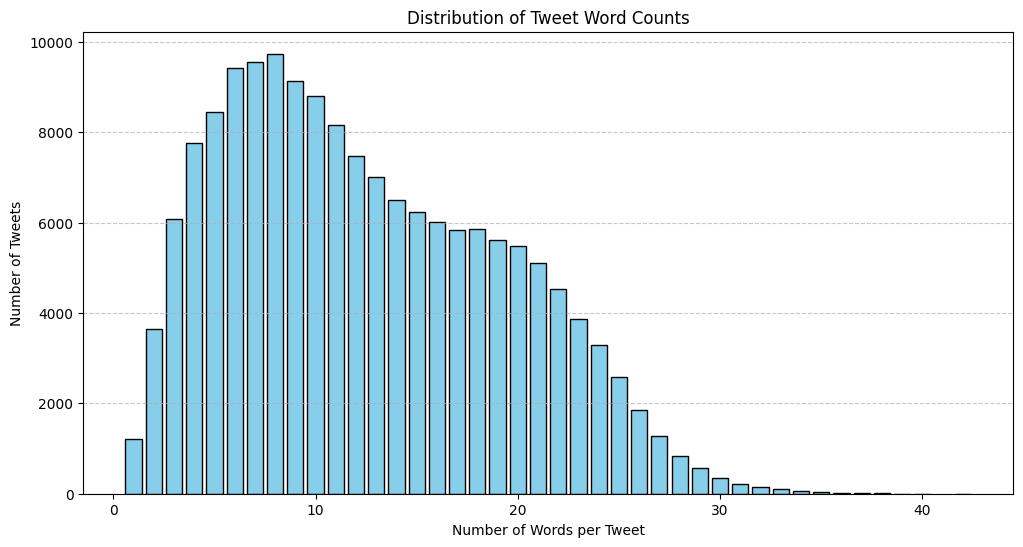

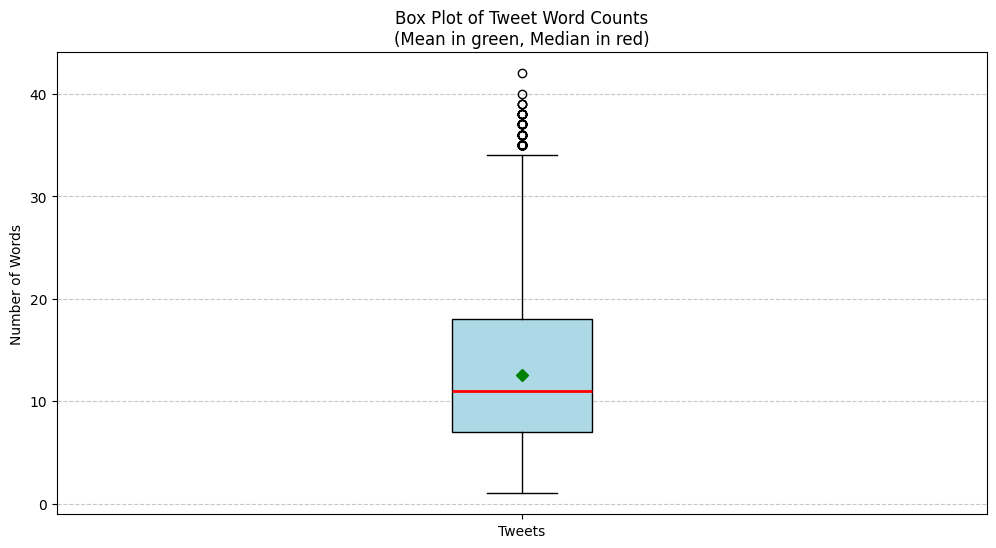

count    162801.000000
mean         12.501397
std           6.806551
min           1.000000
25%           7.000000
50%          11.000000
75%          18.000000
max          42.000000
Name: lemmatized, dtype: float64


In [37]:
# Function to count words in a string, ignoring punctuation
def count_words(text):
    # Remove punctuation using regex
    text_clean = re.sub(r"[^\w\s]", "", text)  # keep only letters, numbers, whitespace
    # Split by whitespace and count words
    return len(text_clean.split())


# Compute number of words for each tweet
word_counts = df["lemmatized"].apply(count_words)

# Count number of tweets for each word count
counts = word_counts.value_counts().sort_index()

# Plot vertical bar chart
plt.figure(figsize=(12, 6))
plt.bar(x=counts.index, height=counts.values, color="skyblue", edgecolor="black")
plt.xlabel("Number of Words per Tweet")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Tweet Word Counts")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Create box plot
plt.figure(figsize=(12, 6))
box = plt.boxplot(
    word_counts,
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),
    medianprops=dict(color="red", linewidth=2),
    showmeans=True,
    meanprops=dict(marker="D", markeredgecolor="green", markerfacecolor="green"),
)
plt.ylabel("Number of Words")
plt.title("Box Plot of Tweet Word Counts\n(Mean in green, Median in red)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([1], ["Tweets"])  # Optional label for x-axis
plt.show()

print(word_counts.describe())

After stopword removal, several changes in the data distribution are apparent. Looking at the histogram, there is a noticeable decrease in tweets with lengths of 30–40 words, reflecting the shortening effect of both lemmatization and stopword removal. The peak of the distribution shifted slightly from 9 to 8 words, with a substantial increase in frequency around this new peak, indicating that many tweets are now concentrated in the short-to-medium length range.

The boxplot shows the emergence of outliers, corresponding to extremely short tweets that remain after stopword removal. The overall distribution has shifted further to the left, reflecting the reduced length of most tweets, while these outliers represent unusually long tweets—common in social media data.

The number of rows decreased slightly, from **162,942** to **162,801**, as tweets consisting entirely of stopwords were removed. Additionally, the mean, spread, and maximum tweet length all decreased, showing a tighter and more consistent distribution.


Since the text preprocessing is now complete, we can show the evolution of the data through three stages:<br>

**Uncleaned text** – the original raw tweets<br>
**Cleaned text** – after initial cleaning, such as removing URLs, mentions, and punctuation<br>
**Cleaned** + preprocessed text – after lemmatization and stopword removal<br>

Displaying these three columns side by side illustrates how the tweets have been transformed at each step.


In [38]:
display(df[["clean_text", "clean_ours", "lemmatized"]].sample(10))

,clean_text,clean_ours,lemmatized
152881,the way congress going will only survive modi wins else due its deeds congress will squeezed badly intelligent anti modi and pro indian public,the way congress going will only survive modi wins else due its deeds congress will squeezed badly intelligent anti modi and pro indian public,congress only survive modi win deed congress squeeze badly intelligent anti modi pro indian public
139863,yes after migs strike modi talking iaf,yes after migs strike modi talking iaf,yes mig strike modi talk iaf
19244,raj gov fault giving opinion favor bjp– may take actionec shd also arrange arrest jailing congresscpim members who instigated murder modi jds member instigating violence against modi supportersaction against ’taka govt for arresting modi supporters,raj gov fault giving opinion favor bjp may take actionec shd also arrange arrest jailing congresscpim members who instigated murder modi jds member instigating violence against modi supportersaction against taka govt for arresting modi supporters,raj gov fault opinion favor bjp actionec shd arrange arrest jail congresscpim member instigate murder modi jds member instigate violence modi supportersaction taka govt arrest modi supporter
40847,wait modi didnt even promise lakhs heres the context\n,wait modi didnt even promise lakhs heres the context,wait modi even promise lakhs context
113906,narendra modi interview previous governments have used defence deals atms says via namo app\n,narendra modi interview previous governments have used defence deals atms says via namo app,narendra modi interview previous government defence deal atms namo app
70698,modi launches leftists “what the need for much drama modi doing publicity before elections”\nrahul launches asat missile leftists “ because great youth leadership gandhi that this possible are superpower now”,modi launches leftists what the need for much drama modi doing publicity before elections rahul launches asat missile leftists because great youth leadership gandhi that this possible are superpower now,modi launch leftist need much drama modi publicity election rahul launch asat missile leftist great youth leadership gandhi possible superpower
20724,congratulationssure you will win become minister modi cabinetgood luck,congratulationssure you will win become minister modi cabinetgood luck,congratulationssure win minister modi cabinetgood luck
113713,this video clearly proves that also vote issues development jobs securitythe liberal media voices should stop there malicious bias propaganda that against,this video clearly proves that also vote issues development jobs securitythe liberal media voices should stop there malicious bias propaganda that against,video clearly prove vote issue development job securitythe liberal medium voice stop malicious bias propaganda
138351,you know that bollywood are always for sale modi brought with force favor junkie chimpanzee watch here,you know that bollywood are always for sale modi brought with force favor junkie chimpanzee watch here,bollywood always sale modi bring force favor junkie chimpanzee watch
48621,modi gave credit all scientists behalf all people mentioned his statement\nplease homework before giving such useless statements\nmodi hateness doesnt mean say lie,modi gave credit all scientists behalf all people mentioned his statement please homework before giving such useless statements modi hateness doesnt mean say lie,modi credit all scientist behalf all people mention statement please homework such useless statement modi hateness lie


In [39]:
df_cleaned = df.copy()
df_cleaned = df_cleaned.drop(["clean_text", "clean_ours"], axis=1)

df_cleaned = df_cleaned[["lemmatized", "category"]]  # for column reordering
df_cleaned["lemmatized"] = df_cleaned["lemmatized"].astype("string")

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162801 entries, 0 to 162941
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   lemmatized  162801 non-null  string
 1   category    162801 non-null  int64 
dtypes: int64(1), string(1)
memory usage: 3.7 MB


The text is now ready for **feature extraction**, which will convert it into numerical representations for modeling.


We have two options for feature extraction: **Bag of Words (BoW)** and **TF-IDF**.

For our dataset, **BoW** seems to have the edge over TF-IDF.

While both methods count word occurrences, TF-IDF additionally downweights words that appear frequently across the corpus. Normally, common words can be a problem for BoW, but since stopwords have already been removed, this is not an issue here. Furthermore, our corpus is very domain-specific, so certain key terms naturally appear often, and TF-IDF could inadvertently reduce their importance. With stopwords removed and a focused domain, BoW keeps the most relevant words front and center, making it a strong choice for this task.


Before delving into the BoW, we provide a brief overview of how it works.


#### **Tokenization**

Since the data cleaning and preprocessing stage is comprehensive, the tokenization step in the BoW model reduces to a simple word-boundary split operation. Each preprocessed entry in the DataFrame is split by spaces. For example, the entry `"shri narendra modis"` (entry: 42052) becomes `["shri", "narendra", "modis"]`. By the end of tokenization, all entries are transformed into arrays of strings.

#### **Word Bigrams**

As noted earlier, modifiers and polarity words are not included in the stopword set. The BoW model constructs a vocabulary containing both unigrams and bigrams. Including bigrams allows the model to capture common word patterns, such as

$$
\left\langle \texttt{Adj}\right\rangle \left\langle \texttt{M} \mid \texttt{Pron} \right\rangle
$$

<center>or</center>

$$
\left\langle \texttt{Adv}\right\rangle \left\langle \texttt{V} \mid \texttt{Adj} \mid \texttt{Adv} \right\rangle
$$

#### **Vector Representation**

After the stemming and lemmatization steps, each entry can now be represented as a vector using a Bag of Words (BoW) model. We employ scikit-learn's `CountVectorizer`, which provides a ready-to-use implementation of BoW <u>(Pedregosa et al., 2011)</u>.

A comparison of other traditional vector representations are discussed in [this appendix](#appendix:-comparison-of-traditional-vectorization-techniques).
Words with modifiers have the modifiers directly attached, enabling subsequent models to capture the concept of modification fully. Consequently, after tokenization and bigram construction, the vocabulary size can grow up to $O(n^2)$, where $n$ is the number of unique tokens.

#### **minimum document frequency constraint:**

Despite cleaning and spam removal, some tokens remain irrelevant or too rare. To address this, a minimum document frequency constraint is applied: $\texttt{min\_df} = 10$, meaning a token must appear in at least 10 documents to be included in the BoW vocabulary. This reduces noise and ensures the model focuses on meaningful terms.

---

These parameters of the BoW model are encapsulated in the `BagOfWordsModel` class. The class definition is available in [this appendix](#appendix:-BagOfWordsModel-class-definition).


In [40]:
bow = BagOfWordsModel(
    texts=df_cleaned["lemmatized"],  # list of words to include in the model
    min_freq=10,  # words must appear in at least 10 different documents to be included
)

# some sanity checks
assert (
    bow.matrix.shape[0] == df_cleaned.shape[0]
), "number of rows in the matrix DOES NOT matches the number of documents"
assert bow.sparsity, "the sparsity is TOO HIGH, something went wrong"

E:\Media Files\Real Stuff\School\Code Files\Cloned Repositories\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


The error above is normal, remember that our tokenization step essentially reduced into an array split step. With this, we need to set the `tokenizer` function attribute of the `BagOfWordsModel` to not use its default tokenization pattern. That causes this warning.


To get an idea of the model, we will now look at its shape and sparsity.<br>

**Shape** - The number of documents and tokens present in the model<br>
**Sparsity** - The number of elements in a matrix that are zero, calculating how sparse or varied the words are in the dataset.


The resulting model has a shape of


In [41]:
print("Bag-of-Words matrix shape:", bow.matrix.shape)

Bag-of-Words matrix shape: (162801, 29318)


The first entry of the pair is the number of documents (the ones that remain after all the data cleaning and preprocessing steps) and the second entry is the number of tokens (or unique words in the vocabulary).

The resulting model has a sparsity of


In [42]:
print("Sparsity:", 1 - bow.sparsity)

Sparsity: 0.9994874290499591


The model is 99.95% sparse, meaning the tweets often do not share the same words leading to a large vocabulary.


Now, looking at the most frequent and least frequent terms in the model.


In [43]:
doc_frequencies = np.asarray((bow.matrix > 0).sum(axis=0)).flatten()
freq_order = np.argsort(doc_frequencies)[::-1]
bow.feature_names[freq_order[:50]]

array(['modi', 'india', 'all', 'people', 'bjp', 'like', 'congress',
       'narendra', 'only', 'election', 'vote', 'narendra modi', 'govt',
       'about', 'year', 'time', 'just', 'country', 'good', 'more',
       'modis', 'rahul', 'nation', 'even', 'indian', 'government', 'work',
       'party', 'power', 'minister', 'win', 'need', 'gandhi', 'support',
       'leader', 'modi govt', 'ask', 'space', 'credit', 'prime', 'money',
       'sir', 'back', 'pakistan', 'chowkidar', 'day', 'prime minister',
       'scientist', 'never', 'today'], dtype=object)

We see that the main talking point of the Tweets, which hovers around Indian politics with keywords like "modi", "india", and "bjp". For additional context, "bjp" referes to the _Bharatiya Janata Party_ which is a conservative political party in India, and one of the two major Indian political parties.

To better understand these, we can check the wordcloud generated from the model.


<function matplotlib.pyplot.show(close=None, block=None)>

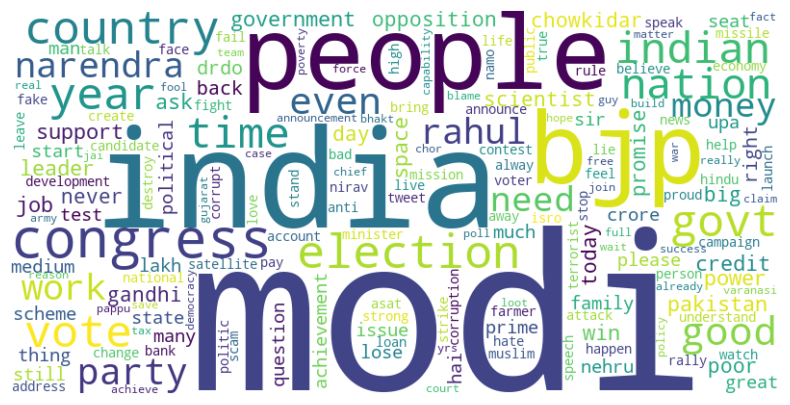

In [44]:
wc = WordCloud(
    width=800, height=400, background_color="white", min_font_size=10
).generate(" ".join(bow.feature_names))
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show

Now, looking at the least popular words.


In [45]:
bow.feature_names[freq_order[-50:]]

array(['wave india', 'wave lose', 'giri', 'girl kidnap', 'good love',
       'transportation', 'trait modi', 'transfer account',
       'goodwill message', 'good service', 'water air', 'good number',
       'goon modi', 'goswami republic', 'gesture modi', 'good stop',
       'government attack', 'government build', 'abcd', 'trivialise',
       'zafar', 'able provide', 'able speak', 'able vote', 'able win',
       'abolish article', 'trend twitter', 'travel modi', 'travel train',
       'good even', 'gng', 'goal post', 'good achievement', 'good always',
       'raid minister', 'unnoticed', 'unofficial', 'bhatt aditi',
       'bhi aur', 'bhi berozgar', 'big danger', 'rajan modi',
       'bhupesh baghel', 'bhutan', 'rakhe', 'rally only', 'bhi mumkin',
       'zara', 'yrs people', 'trolled liberal'], dtype=object)

We still see that the themes mentioned in the most frequent terms are still present in this subset. Although, more filler or non-distinct words do appear more often, like "photos", "soft" and "types".

But the present of words like "reelection" and "wars" still point to this subset still being relevant to the main theme of the dataset.


# **4. Dataset Splitting**

Before being able to use the dataset, we need to partition it into three sets:

1. **Training** - used to train the model to learn and change its parameters
2. **Validation** - used to evaluate the model, comparing its predictions to correct answers for hyperparameter tuning
3. **Test** - used to test the model with new, unseen data

The following section will be dedicated solely to splitting the dataset. We will split the dataset with 70% for training, 15% for validation, and 15% for testing as this is a standard partitioning.

## **Splitting the dataset into Training, Validation, and Testing sets**

We'll first split the dataset into 70% and 30% parts by using Scikit-learn's `train_test_split` function. As mentioned earlier, the distribution of categories is imbalanced, so we have to use the function's `stratify` parameter to maintain an even proportion.


In [46]:
train, temp = train_test_split(
    df_cleaned, test_size=0.3, stratify=df_cleaned["category"], random_state=5
)  # 70/30 split

print(train.shape, temp.shape)

(113960, 2) (48841, 2)


We now have our two sets for training and testing, but we're still missing one more for validation. We can split the 30% part into two halves of 15% so that we have a part for validation and the other part for testing.


In [47]:
validation, test = train_test_split(
    temp, test_size=0.5, stratify=temp["category"], random_state=5
)  # 15/15 split

print(train.shape, validation.shape, test.shape)

(113960, 2) (24420, 2) (24421, 2)


Now that we have our training, validation, and testing sets, we can use these on the models.


# **References**

Bird, S., & Loper, E. (2004, July). NLTK: The natural language toolkit. _Proceedings of the ACL Interactive Poster and Demonstration Sessions_, 214–217. https://aclanthology.org/P04-3031/

El-Demerdash, A. A., Hussein, S. E., & Zaki, J. F. W. (2021). Course evaluation based on deep learning and SSA hyperparameters optimization. _Computers, Materials & Continua, 71_(1), 941–959. https://doi.org/10.32604/cmc.2022.021839

George, M., & Murugesan, R. (2024). Improving sentiment analysis of financial news headlines using hybrid Word2Vec-TFIDF feature extraction technique. _Procedia Computer Science, 244_, 1–8.

Honnibal, M., Montani, I., Van Landeghem, S., & Boyd, A. (2020). spaCy: Industrial-strength Natural Language Processing in Python. https://doi.org/10.5281/zenodo.1212303

Hussein, S. (2021). _Twitter sentiments dataset_. Mendeley.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. _Journal of Machine Learning Research, 12_, 2825–2830.

Rani, D., Kumar, R., & Chauhan, N. (2022, October). Study and comparison of vectorization techniques used in text classification. In _2022 13th International Conference on Computing Communication and Networking Technologies (ICCCNT)_ (pp. 1–6). IEEE.

Wolfram Research. (2015). _DeleteStopwords_. https://reference.wolfram.com/language/ref/DeleteStopwords.html


# **Appendix: `clean` wrapper function definition**

Below is the definition of the `clean` wrapper function that encapsulates all internal functions used in the cleaning pipeline.


In [48]:
clean??

# **Appendix: `find_spam_and_empty` wrapper function definition**

Below is the definition of the `find_spam_and_empty` wrapper function that encapsulates all internal functions for the spam detection algorithm.


In [49]:
find_spam_and_empty??

# **Appendix: comparison of traditional vectorization techniques**

Traditional vectorization techniques include BoW and Term Frequency-Inverse Document Frequency (TF-IDF). TF-IDF weights each word based on its frequency in a document and its rarity across the corpus, reducing the impact of common words. BoW, in contrast, simply counts word occurrences without considering corpus-level frequency. In this project, BoW was chosen because stopwords were already removed during preprocessing, and the dataset is domain-specific <u>(Rani et al., 2022)</u>. In such datasets, frequent words are often meaningful domain keywords, so scaling them down (as TF-IDF would) could reduce the importance of these key terms in the feature representation.


# **Appendix: `BagOfWordsModel` class definition**

Below is the definition of the `BagOfWordsModel` class that encapsulates the desired parameters.


In [50]:
BagOfWordsModel??